Taken from the Qiskit notebook for Quantum Counting

# Quantum Counting algorithm (ascending)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from depolar import depolarizing_channel

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.aqua.circuits.gates.multi_control_toffoli_gate import _cccx

# import basic plot tools
from qiskit.visualization import plot_histogram

def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m-1)))*(2**(-m))
    print("Error < %.2f" % err)

def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    q = QuantumRegister(4, 'q')
    circ = QuantumCircuit(q)
    # Oracle
    circ.h(3)
    _cccx(circ,q)
    circ.x(0)
    _cccx(circ,q)
    circ.x(0)
    circ.x(1)
    _cccx(circ,q)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.x(2)
    _cccx(circ,q)
    circ.x(2)
    circ.x(1)
    circ.h(3)
    # Diffusion Operator
    circ.z(3)
    for qubit in q[:3]:
        circ.h(qubit)
        circ.x(qubit)
    _cccx(circ,q)
    for qubit in q[:3]:
        circ.x(qubit)
        circ.h(qubit)
    circ.z(3)
    return circ

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cu1(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

def counting():
    qreg = QuantumRegister(8, 'q')   # First 4 are for counting, last 4 for 'searching'
    t = 4   # no. of counting qubits
    n = 4   # no. of searching qubits
    creg = ClassicalRegister(4, 'c')
    circ = QuantumCircuit(qreg, creg)

    # Create controlled-Grover
    grit = example_grover_iteration().to_gate()
    cgrit = grit.control()

    qft_dagger = qft(QuantumCircuit(4),4).to_gate().inverse()

    # Initialise all qubits to |+>
    for qubit in qreg:
        circ.h(qubit)

    # Begin controlled Grover iterations
    iterations = 1
    for qubit in qreg[:4]:
        for i in range(iterations):
            circ.append(cgrit, qargs=[qubit] + qreg[4:])
            for j in range(0,4):
                depolarizing_channel(circ,4+j,decoherence_percent)
            depolarizing_channel(circ,qubit,decoherence_percent)
        iterations *= 2

    # Do inverse QFT on counting qubits
    circ.append(qft_dagger, qargs=qreg[:4])

    # Measure Qubits
    circ.measure(qreg[:4],creg)

    #circ.draw(output='mpl')
    return circ

### Single Circuit Trial

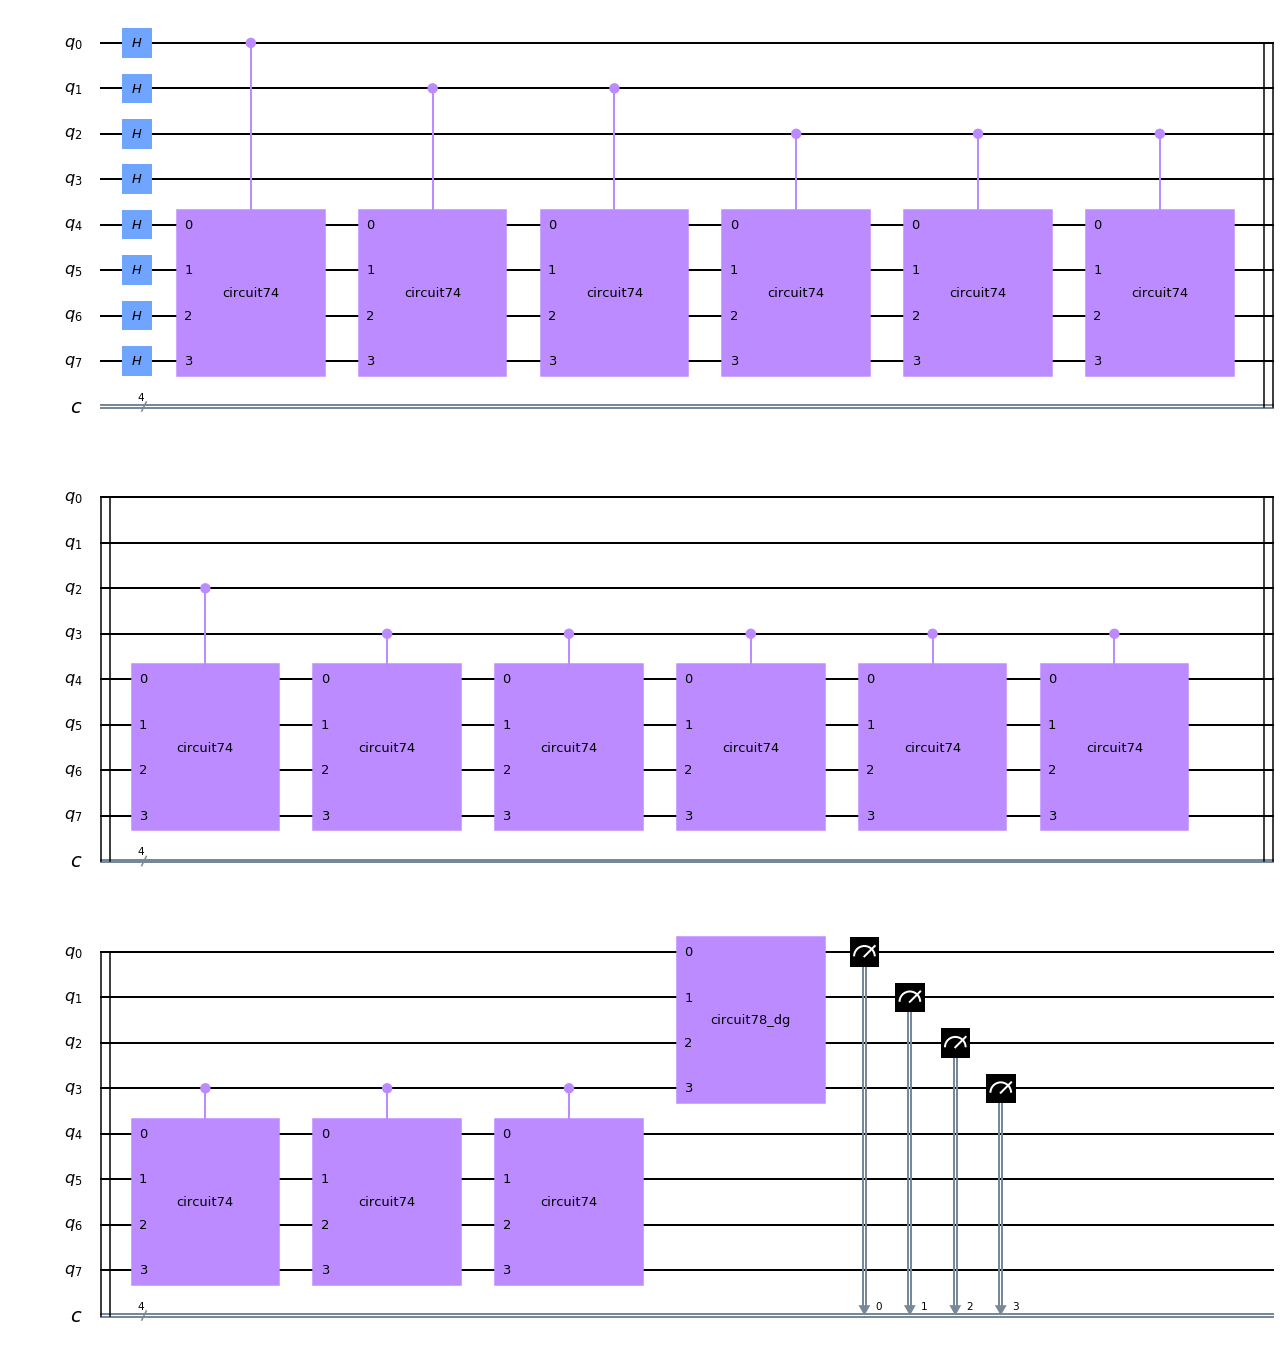

In [13]:
decoherence_percent = 0.1
circ = counting()
circ.draw(output="mpl")

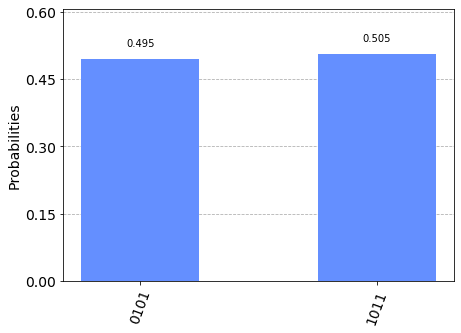

In [10]:
# Execute and see results
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=2048 )
hist = job.result().get_counts()
plot_histogram(hist)

In [11]:
calculate_M(int(max(hist, key=hist.get),2),4,4)

Theta = 4.31969
No. of Solutions = 4.9
Error < 2.85


### Multiple Trials

In [ ]:
decoherence_percent = 0.1
trials = 3
f = open("trial_results/qc_ascending.txt", "w")
for i in range(trials):
    output = str(i) + ": "
    circ = counting()
    emulator = Aer.get_backend('qasm_simulator')
    job = execute(circ, emulator, shots=2048 )
    hist = job.result().get_counts()
    output = output + str(hist) + "\n"
    f.write(output)
f.close()